<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('gdalutils')
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘gdalutils’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this packag

# New Section

In [ ]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [ ]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=03068e47c995af8a59b4adb6c7b690ed&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWRldTVCV085N084M2t1RWpNdGZTZlNESzFzcjdORXhaT0pCRWt1b2x6NTdFVnJRTHVfOGNNNmppTEh5SXNES2ZIM0NHUSIsInN0YXRlIjoiMDMwNjhlNDdjOTk1YWY4YTU5YjRhZGI2YzdiNjkwZWQifQ==


In [ ]:
# Hawaii
# Kahoolawe
# Kauai
# Lanai
# Maui
# Molokai
# Niihau
# Oahu


### CCAP 2005 Data
### Hawaii
*   CCAP: https://drive.google.com/file/d/1alePZ56pp-Z7FmayRAkACT3y-kwty6W3/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1OJWmvCpa3pCR8RA2erqKdIrNx9UrNG2S/view?usp=drive_link
### Kahoolawe
*   CCAP: https://drive.google.com/file/d/17IpuHwb3tioOtNAAnxT0bp9FGwddaLvJ/view?usp=drive_link
*   LS: ***part of Maui LS***
### Kauai
*   CCAP: https://drive.google.com/file/d/1LvFnOVel0exNQl_N56CPBe05YQK5xrm2/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1LJ6QSVenPmYVy6Xb6PnxbBtAtcihq26a/view?usp=drive_link
### Lanai
*   CCAP: https://drive.google.com/file/d/1ZJHzCSIMotmgcNPeqFG2kZrX0omb-Rba/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1m0sGxOy3u3SYQFPHt854x_3-JAyujcna/view?usp=drive_link
### Maui
*   CCAP: https://drive.google.com/file/d/1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1wmSLERJJV4geHFzsUv8hMDWbO7TX4zVr/view?usp=drive_link
### Molokai
*   CCAP: https://drive.google.com/file/d/1DcyMGYwQ538ZeKCXJDbPFjI4F4mZrdUM/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1-oSCrCd2KWYnqLAin_TzjxIKJTBueQeL/view?usp=drive_link
### Niihau
*   CCAP: https://drive.google.com/file/d/1DByagFnHZbFeMyGtVSBj1biXkAy0h__w/view?usp=drive_link
*   LS: https://drive.google.com/file/d/17cvOubTQUCC49r8gFasfQLd5s0YiZKoo/view?usp=drive_link
### Oahu
*   CCAP: https://drive.google.com/file/d/1bILhjVbU4EN-pQUvgnOxW_WXW9WJ5U3y/view?usp=drive_link
*   LS: https://drive.google.com/file/d/1ofXyec-OTqfWhy6Qjh69kXDpezIShWiK/view?usp=drive_link


In [ ]:
# dir.create('/content/Hawaii/') # 2005_Hawaii_CCAP # 2005_Hawaii_LS

# dir.create('/content/Kauai/') # 2005_Kauai_CCAP # 2005_Kauai_LS

# dir.create('/content/Lanai/') # 2005_Lanai_CCAP # 2005_Lanai_LS

# dir.create('/content/Maui/') # 2005_Maui_CCAP # 2005_Maui_LS

# dir.create('/content/Molokai/') # 2005_Molokai_CCAP # 2005_Molokai_LS

# dir.create('/content/Niihau/') # 2005_Niihau_CCAP # 2005_Niihau_LS

# dir.create('/content/Oahu/') # 2005_Oahu_CCAP # 2005_Oahu_LS


In [ ]:
# # Hawaii
# # CCAP: https://drive.google.com/file/d/1alePZ56pp-Z7FmayRAkACT3y-kwty6W3/view?usp=drive_link
# drive_download(file = as_id('1alePZ56pp-Z7FmayRAkACT3y-kwty6W3'), path =  '/content/Hawaii/2005_Hawaii_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1OJWmvCpa3pCR8RA2erqKdIrNx9UrNG2S/view?usp=drive_link
# drive_download(file = as_id('1OJWmvCpa3pCR8RA2erqKdIrNx9UrNG2S'), path =  '/content/Hawaii/2005_Hawaii_LS.tif', overwrite = TRUE)

# # Kauai
# # CCAP: https://drive.google.com/file/d/1LvFnOVel0exNQl_N56CPBe05YQK5xrm2/view?usp=drive_link
# drive_download(file = as_id('1LvFnOVel0exNQl_N56CPBe05YQK5xrm2'), path =  '/content/Kauai/2005_Kauai_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1LJ6QSVenPmYVy6Xb6PnxbBtAtcihq26a/view?usp=drive_link
# drive_download(file = as_id('1LJ6QSVenPmYVy6Xb6PnxbBtAtcihq26a'), path =  '/content/Kauai/2005_Kauai_LS.tif', overwrite = TRUE)

# # Lanai
# # CCAP: https://drive.google.com/file/d/1ZJHzCSIMotmgcNPeqFG2kZrX0omb-Rba/view?usp=drive_link
# drive_download(file = as_id('1ZJHzCSIMotmgcNPeqFG2kZrX0omb-Rba'), path =  '/content/Lanai/2005_Lanai_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1m0sGxOy3u3SYQFPHt854x_3-JAyujcna/view?usp=drive_link
# drive_download(file = as_id('1m0sGxOy3u3SYQFPHt854x_3-JAyujcna'), path =  '/content/Lanai/2005_Lanai_LS.tif', overwrite = TRUE)

# # Maui
# # CCAP: https://drive.google.com/file/d/1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9/view?usp=drive_link
# drive_download(file = as_id('1Zad7crYgAO6TywmxZ8bUof3XdBobNTX9'), path =  '/content/Maui/2005_Maui_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1wmSLERJJV4geHFzsUv8hMDWbO7TX4zVr/view?usp=drive_link
# drive_download(file = as_id('1wmSLERJJV4geHFzsUv8hMDWbO7TX4zVr'), path =  '/content/Maui/2005_Maui_LS.tif', overwrite = TRUE)

# Molokai
# # CCAP: https://drive.google.com/file/d/1DcyMGYwQ538ZeKCXJDbPFjI4F4mZrdUM/view?usp=drive_link
# drive_download(file = as_id('1DcyMGYwQ538ZeKCXJDbPFjI4F4mZrdUM'), path =  '/content/Molokai/2005_Molokai_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1-oSCrCd2KWYnqLAin_TzjxIKJTBueQeL/view?usp=drive_link
# drive_download(file = as_id('1-oSCrCd2KWYnqLAin_TzjxIKJTBueQeL'), path =  '/content/Molokai/2005_Molokai_LS.tif', overwrite = TRUE)

# Niihau
# # CCAP: https://drive.google.com/file/d/1DByagFnHZbFeMyGtVSBj1biXkAy0h__w/view?usp=drive_link
# drive_download(file = as_id('1DByagFnHZbFeMyGtVSBj1biXkAy0h__w'), path =  '/content/Niihau/2005_Niihau_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/17cvOubTQUCC49r8gFasfQLd5s0YiZKoo/view?usp=drive_link
# drive_download(file = as_id('17cvOubTQUCC49r8gFasfQLd5s0YiZKoo'), path =  '/content/Niihau/2005_Niihau_LS.tif', overwrite = TRUE)

# # Oahu
# # CCAP: https://drive.google.com/file/d/1bILhjVbU4EN-pQUvgnOxW_WXW9WJ5U3y/view?usp=drive_link
# drive_download(file = as_id('1bILhjVbU4EN-pQUvgnOxW_WXW9WJ5U3y'), path =  '/content/Oahu/2005_Oahu_CCAP.tif', overwrite = FALSE)
# # LS: https://drive.google.com/file/d/1ofXyec-OTqfWhy6Qjh69kXDpezIShWiK/view?usp=drive_link
# drive_download(file = as_id('1ofXyec-OTqfWhy6Qjh69kXDpezIShWiK'), path =  '/content/Oahu/2005_Oahu_LS.tif', overwrite = TRUE)

Auto-refreshing stale OAuth token.

File downloaded:

• hi_molokai_2005_ccap_hr_land_cover20150102.img
  <id: 1mD_aqCyjKKpbCAFmNMak5I1NrxodGCg1>

Saved locally as:

• /content/test/2005_CCAP_Molokai.tif

File downloaded:

• Molokai_01-04.tif <id: 1TNapEw3HC2g4y93sla8fhR5iQnWVIqpw>

Saved locally as:

• /content/test/2005_LS_Molokai.tif



In [ ]:
ccap_raster <- stack('/content/Hawaii/2005_Hawaii_CCAP.tif')
ls_raster <- stack('/content/Hawaii/2005_Hawaii_LS.tif')

In [ ]:
ls_raster_extended <- extend(ls_raster, projectExtent(ccap_raster, ls_raster), value=NA)

In [ ]:
ccap_raster
ls_raster

class      : RasterStack 
dimensions : 9851, 27629, 272173279, 1  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 673773.6, 740083.2, 2326722, 2350364  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=WGS84 +units=m +no_defs 
names      : Class.Name 
min values :          0 
max values :         21 


class      : RasterStack 
dimensions : 1066, 2658, 2833428, 7  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -157.3668, -156.6505, 20.99309, 21.28037  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue, Green, Red, NIR, SWIR1, SWIR2, pixel_qa 


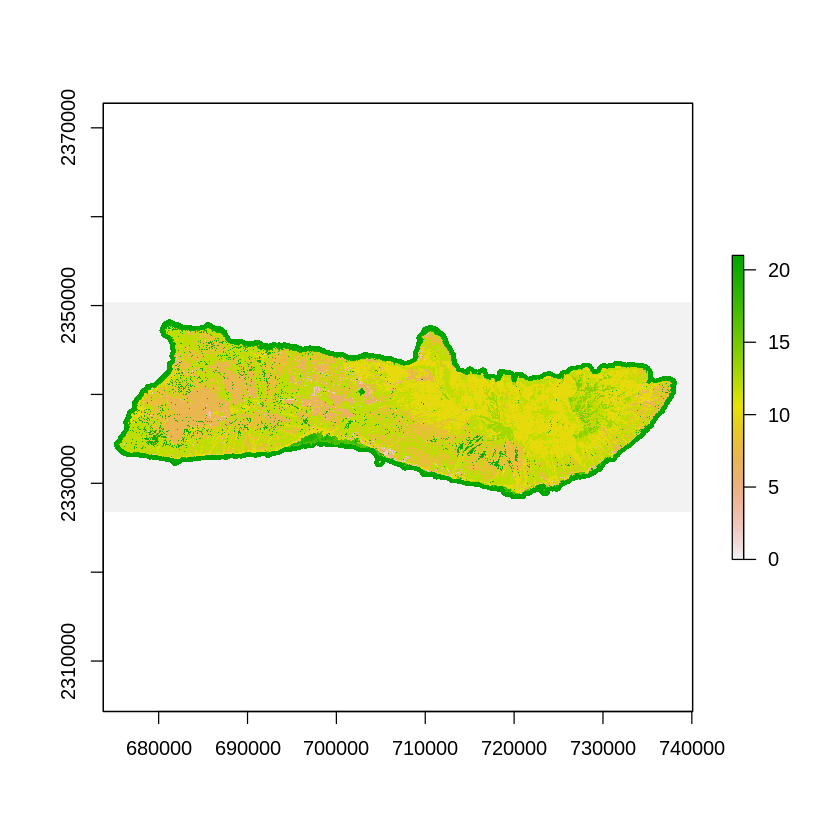

In [ ]:
ccap_raster %>% plot

In [ ]:
ncol(ccap_raster)

nrow(ccap_raster)


y_end <- c(seq(1,ccap_raster %>% nrow,512),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,512),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)

[1] 27629

[1] 9851

In [ ]:

# dir.create('/TrainingData/Hawaii')
# Specify the path for the new folder/directory
new_folder_path <- "/content/TrainingData/Hawaii/Images"
new_folder_path2 <- "/content/TrainingData/Hawaii/Labels"
# Use dir.create to create the new folder
dir.create(new_folder_path, showWarnings = FALSE)

# Check if the folder was created successfully
if (file.exists(new_folder_path)) {
  cat("Folder created:", new_folder_path, "\n")
} else {
  cat("Failed to create folder:", new_folder_path, "\n")
}


# Use dir.create to create the new folder
dir.create(new_folder_path2, showWarnings = FALSE)
# Check if the folder was created successfully
if (file.exists(new_folder_path2)) {
  cat("Folder created:", new_folder_path2, "\n")
} else {
  cat("Failed to create folder:", new_folder_path2, "\n")
}

Folder created: /content/TrainingData/Metadata/Images 
Folder created: /content/TrainingData/Metadata/Labels 


In [ ]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=512 | ncol != 512){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(ccap_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(ccap_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(ccap_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(ccap_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    ccap_cropped_raster <- crop(ccap_raster, e)

    nrow <- nrow(ccap_cropped_raster)
    ncol <- ncol(ccap_cropped_raster)


    # print(dim(ccap_cropped_raster))
    if(i>1000){return('failed to converge')}
    }

  ls_cropped_raster <- crop(ls_raster_extended, projectExtent(ccap_cropped_raster,ls_raster))

  ls_resampled_raster <- projectRaster(ls_cropped_raster,ccap_cropped_raster)
  print(ls_resampled_raster)
  pixel_table <- (table(values(ccap_cropped_raster))/ncell(ccap_cropped_raster)) %>% data.table

  names(pixel_table) <- c('label','percent')

  out_dt <- data.table(extract_grid[x,],xmin = xmin,xmax =xmax,ymin= ymin,ymax, pixel_table)

  if(ls_resampled_raster %>% nrow ==512 & ls_resampled_raster %>% ncol ==512 & ccap_cropped_raster%>% nrow ==512 & ccap_cropped_raster%>% ncol ==512){
    ls_resampled_raster %>%
    writeRaster(., paste("/content/TrainingData/Hawaii/Images",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)

    ccap_cropped_raster %>%
    writeRaster(., paste("/content/TrainingData/Hawaii/Labels",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  }else(print('uh oh'))

  return(out_dt)
})
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/TrainingData/Hawaii/Hawaii.csv") # /content/TrainingData/Hawaii

class      : RasterBrick 
dimensions : 512, 512, 262144, 7  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 673773.6, 675002.4, 2349133, 2350362  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=WGS84 +units=m +no_defs 
source     : memory
names      :     Blue,    Green,      Red,      NIR,    SWIR1,    SWIR2, pixel_qa 
min values : 412.0422, 360.9663, 279.3137, 585.6523, 396.6332, 299.2164,  68.0000 
max values : 543.2353, 507.9209, 464.8269, 787.8207, 605.5007, 460.4014,  68.0000 

class      : RasterBrick 
dimensions : 512, 512, 262144, 7  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 675004.8, 676233.6, 2349135, 2350364  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=WGS84 +units=m +no_defs 
source     : memory
names      :     Blue,    Green,      Red,      NIR,    SWIR1,    SWIR2, pixel_qa 
min values : 402.6026, 351.0000, 269.4023, 579.1026, 382.0390, 271.1853,  68.0000 
max values : 515.0732, 469.2

In [ ]:
zip(zipfile = "/content/TrainingData/Hawaii.zip", files = "/content/TrainingData/Hawaii")

Warning message in fix_absolute_paths(data$key):
“Dropping leading `/` from paths, all paths in a zip file must be relative paths.”


In [ ]:
# revised_trainingdata https://drive.google.com/drive/folders/1s7g2RtSXxgH6l1PdZGQwkGn7AGPueGB5?usp=drive_link
drive_upload(media = "/content/TrainingData/Hawaii.zip", path = as_id("1s7g2RtSXxgH6l1PdZGQwkGn7AGPueGB5"))

Auto-refreshing stale OAuth token.

Local file:

• /content/TrainingData/Metadata.zip

Uploaded into Drive file:

• Metadata.zip <id: 14hy5BfOO7ixzHMb_AM9-i_m9HZ4DVoq3>

With MIME type:

• application/zip

